# 2D CNN with Laplace Beltrami Spectrum

## Binary Classification: Males vs. Females

Here we are going to see if we can create a 2 dimensional convolutional neural network that can classify a subject as male or female based on the shape (LB spectrum) of their white matter tracts.

The initial set up will be very similar to the MLP and 1D CNN, but the final shape of the data will be different. The network architecture will be similar to the 2D CNN, but they will be 2D convolutional layers instead of 1D. 


### Import libraries
First, let's import the libraries we will use.

In [1]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import and check the data
Now let's read in the data using pickle. The data was previously processed in python and saved down using pickle. This will be the same steps as used in the MLP notebook so I will not include as many comments

In [2]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
# list of tracts we want to use
tractstouse = pickle.load(open('tractstouse.pk','rb'))
# subject list
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
# list of subject gender 1 = male, 2 = female
gender_id = pickle.load(open('gender_id.pk','rb'))

### Preprocess the data
The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a 2D matrix per subject. We will have one row per tract and one column per eigenvalue.

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's StandardScaler function.

**Normalize the data**

In [3]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict


In [4]:
# normalize all of the tracts so that each ev is centered on 0.
tractev_dict_600_scaled = scale_ev_dict(tractev_dict_600)

### Reorganize the data

Currently the data is a dictionary of 2D matrices, we want to reorganize this into an array of 2D matrices with the shape (num subjects, num tracts, num eigenvalues, 1).

It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary.

In [5]:
#numeber of evs to use per tract. We will keep it the same for all.
numev = 200

# change the organization to be an array with one row per tract and one row per ev, per subj.

allsubjs_alltracts_array = np.zeros([len(HCP_subj_list), len(tractstouse), numev])
for i in range(len(tractstouse)):
    allsubjs_alltracts_array[:, i, :] = tractev_dict_600_scaled[tractstouse[i]][:, 0:numev]


In [6]:
allsubjs_alltracts_array.shape

(1013, 48, 200)

In [7]:
allsubjs_alltracts_array = allsubjs_alltracts_array.reshape(allsubjs_alltracts_array.shape[0],allsubjs_alltracts_array.shape[1], allsubjs_alltracts_array.shape[2], 1)

allsubjs_alltracts_array = allsubjs_alltracts_array.astype('float32')


In [8]:
allsubjs_alltracts_array.shape

(1013, 48, 200, 1)

**one hot encode the labels**

In [9]:
# one-hot encoding for the gender ID
genderid_ohe = np.asarray(gender_id) - 1
genderid_ohe = genderid_ohe.astype('float32')

### Split the data
The input data is now preprocessed and ready to be input into a neural network. However, we first have to split the data into training, validation, and testing sets. We do not have a ton of samples, so we will try splitting the data into 3 subsets first and then explore other cross validation options if necessary.




In [10]:
X = allsubjs_alltracts_array
Y = genderid_ohe

#first split the training/validation data from the testing data
trainvalX, testX, trainvalY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainvalX) 
print len(testX)

810
203


In [11]:
#second split the validation data from the training data
trainX, valX, trainY, valY = train_test_split(trainvalX, trainvalY, train_size  = .75, test_size = .25, random_state=0)

print len(trainX)
print len(valX)

607
203


Now we have 3 subsets of data. Training data with 607 samples, validation data with 203 samples, and testing data with 203 samples. Again, this may be too few samples for training and if so we can employ other cross validation methods.

Let's first define our function for plotting the training history.

In [12]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

In [13]:
from keras import backend as K
import gc

In [14]:
#sometimes python does not release memory very well on its own, these help clear memory
K.clear_session()
gc.collect()

12

Let's try a model architecture similar to the one we used with the 1D CNN but let's add a MaxPooling layer at the end to reduce some of the dimensionality before the final dense layer.

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 3s 5ms/step - loss: 0.7090 - acc: 0.4679 - val_loss: 0.6916 - val_acc: 0.5567
Epoch 2/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6855 - acc: 0.5519 - val_loss: 0.6874 - val_acc: 0.5764
Epoch 3/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6799 - acc: 0.5684 - val_loss: 0.6829 - val_acc: 0.5862
Epoch 4/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6742 - acc: 0.5997 - val_loss: 0.6762 - val_acc: 0.6256
Epoch 5/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6673 - acc: 0.5964 - val_loss: 0.6677 - val_acc: 0.6453
Epoch 6/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6567 - acc: 0.6491 - val_loss: 0.6576 - val_acc: 0.6601
Epoch 7/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6465 - acc: 0.6557 - val_loss: 0.6436 - val_acc: 0.6897
Epoch 8/60
607/607 [==========

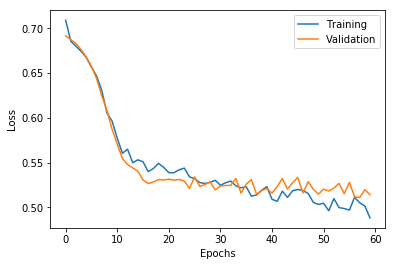

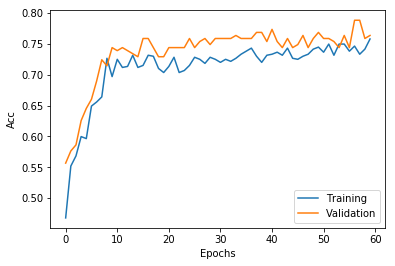

In [15]:
adam = Adam(lr=.00001)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],allsubjs_alltracts_array.shape[2],1)))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=60, batch_size=10, validation_data=(valX, valY))


plot_history(history)


The highest validation accuracy was 79%. This is a good start. Let's add in regularization and change some of the parameters.

In [31]:
from keras.regularizers import l1, l2, l1_l2

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 4s 6ms/step - loss: 0.8173 - acc: 0.5502 - val_loss: 0.7481 - val_acc: 0.7685
Epoch 2/20
607/607 [==============================] - 2s 3ms/step - loss: 0.7064 - acc: 0.6656 - val_loss: 0.6599 - val_acc: 0.7340
Epoch 3/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6568 - acc: 0.6952 - val_loss: 0.6439 - val_acc: 0.7635
Epoch 4/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6451 - acc: 0.7051 - val_loss: 0.6294 - val_acc: 0.7635
Epoch 5/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6252 - acc: 0.7166 - val_loss: 0.6204 - val_acc: 0.7734
Epoch 6/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6379 - acc: 0.7018 - val_loss: 0.6258 - val_acc: 0.7833
Epoch 7/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6179 - acc: 0.7068 - val_loss: 0.6059 - val_acc: 0.7685
Epoch 8/20
607/607 [==========

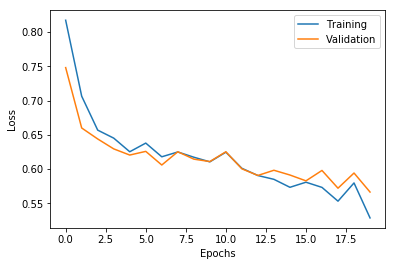

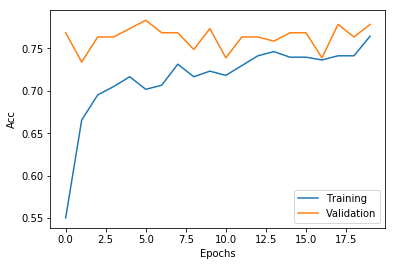

In [36]:
adam = Adam(lr=.0001)

model = Sequential()
model.add(Conv2D(100, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],
                                                                       allsubjs_alltracts_array.shape[2],1),
                                                                         kernel_regularizer=l2(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(MaxPooling2D())
model.add(Dropout(0.7))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(300, activation='relu', kernel_regularizer=l2(.0001)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=20, validation_data=(valX, valY))


plot_history(history)

The highest validation accuracy was 78%, so this did not help much. Let's try removing that final MaxPooling layer. 

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 3s 6ms/step - loss: 1.3254 - acc: 0.6129 - val_loss: 1.2269 - val_acc: 0.7635
Epoch 2/20
607/607 [==============================] - 1s 2ms/step - loss: 1.2068 - acc: 0.7348 - val_loss: 1.1371 - val_acc: 0.7734
Epoch 3/20
607/607 [==============================] - 1s 2ms/step - loss: 1.2036 - acc: 0.7282 - val_loss: 1.1749 - val_acc: 0.7094
Epoch 4/20
607/607 [==============================] - 1s 2ms/step - loss: 1.1495 - acc: 0.7430 - val_loss: 1.1009 - val_acc: 0.8030
Epoch 5/20
607/607 [==============================] - 1s 2ms/step - loss: 1.1057 - acc: 0.7727 - val_loss: 1.0859 - val_acc: 0.7980
Epoch 6/20
607/607 [==============================] - 1s 2ms/step - loss: 1.0850 - acc: 0.7908 - val_loss: 1.0710 - val_acc: 0.7882
Epoch 7/20
607/607 [==============================] - 1s 2ms/step - loss: 1.0445 - acc: 0.8105 - val_loss: 1.0541 - val_acc: 0.8079
Epoch 8/20
607/607 [==========

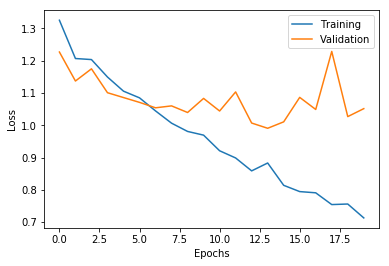

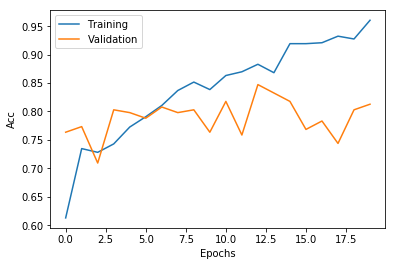

In [43]:
adam = Adam(lr=.0001)

model = Sequential()
model.add(Conv2D(80, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],
                                                                       allsubjs_alltracts_array.shape[2],1),
                                                                         kernel_regularizer=l1(.0001)))
model.add(Conv2D(80, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
# model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(300, activation='relu', kernel_regularizer=l2(.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=20, validation_data=(valX, valY))


plot_history(history)

Removing the final MaxPooling layer helped a lot. We were able to reach a validation classificaiton accuracy of 84%. 